In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

 # Imports


In [2]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image


# Load Data

In [3]:
data_train_path = "/kaggle/input/fruits/fruits-360_dataset_original-size/fruits-360-original-size/Training"
data_validation_path = "/kaggle/input/fruits/fruits-360_dataset_original-size/fruits-360-original-size/Validation"

IMAGE_SHAPE = (224, 224)
batch_size = 32
epochs=50

## Preprocessing and normalization  

In [4]:
def preprocess_image(image, label):
    image = tf.image.resize(image, list(IMAGE_SHAPE))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

In [5]:
raw_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_train_path,
    image_size=IMAGE_SHAPE,
    batch_size=batch_size,
    shuffle=True
)

raw_validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_validation_path,
    image_size=IMAGE_SHAPE,
    batch_size=batch_size,
    shuffle=True
)

Found 6231 files belonging to 24 classes.
Found 3114 files belonging to 24 classes.


In [6]:
dataset = raw_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = raw_validation_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

In [7]:
class_names = raw_dataset.class_names
class_names

['apple_6',
 'apple_braeburn_1',
 'apple_crimson_snow_1',
 'apple_golden_1',
 'apple_golden_2',
 'apple_golden_3',
 'apple_granny_smith_1',
 'apple_hit_1',
 'apple_pink_lady_1',
 'apple_red_1',
 'apple_red_2',
 'apple_red_3',
 'apple_red_delicios_1',
 'apple_red_yellow_1',
 'apple_rotten_1',
 'cabbage_white_1',
 'carrot_1',
 'cucumber_1',
 'cucumber_3',
 'eggplant_long_1',
 'pear_1',
 'pear_3',
 'zucchini_1',
 'zucchini_dark_1']

# Training

## SetUp MobileNetV2 as base model

In [8]:
 base_model = MobileNetV2(
        weights="imagenet",
        include_top=False,
        input_shape=IMAGE_SHAPE + (3,),
        alpha=0.35,
    )

2019640/2019640 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
 base_model.trainable = False

## Build Model

In [10]:
 model = Sequential(
        [
            base_model,
            GlobalAveragePooling2D(),
            Dense(256, activation="relu"),
            Dropout(0.5),
            Dense(len(class_names), activation="softmax", dtype="float32"),
        ]
    )

In [11]:
model.compile(
    optimizer=Adam(learning_rate=0.001, amsgrad=True),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

In [12]:
early_stopping = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.0001,
    patience=5,
    restore_best_weights=True,
)

In [13]:
 model_checkpoint = ModelCheckpoint(
    "fruits_360_model.keras",
    save_best_only=True,
    monitor="val_accuracy",
    mode="auto",
    save_freq="epoch",
)

## logger

In [14]:
logdir = os.path.join('..', 'logs')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

## fit Model

In [15]:
with tf.device("GPU:0"):
   hist = model.fit(dataset,epochs=epochs,validation_data=validation_dataset, callbacks=[early_stopping, model_checkpoint, tensorboard_callback],)

Epoch 1/50
  1/195 ━━━━━━━━━━━━━━━━━━━━ 47:17 15s/step - accuracy: 0.0000e+00 - loss: 3.6050

I0000 00:00:1724002437.395037      78 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1724002437.431587      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7105 - loss: 1.0257

W0000 00:00:1724002454.990272      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724002458.634449      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724002467.842266      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


195/195 ━━━━━━━━━━━━━━━━━━━━ 46s 159ms/step - accuracy: 0.7114 - loss: 1.0226 - val_accuracy: 0.9981 - val_loss: 0.0222
Epoch 2/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.9926 - loss: 0.0488 - val_accuracy: 0.9990 - val_loss: 0.0069
Epoch 3/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.9964 - loss: 0.0238 - val_accuracy: 0.9997 - val_loss: 0.0028
Epoch 4/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.9989 - loss: 0.0099 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 5/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.9996 - loss: 0.0072 - val_accuracy: 1.0000 - val_loss: 8.8311e-04
Epoch 6/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.9995 - loss: 0.0044 - val_accuracy: 1.0000 - val_loss: 8.4149e-04
Epoch 7/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9988 - loss: 0.0057 - val_accuracy: 1.0000 - val_loss: 6.4559e-04
Epoch 8/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.9995 - loss: 0.0036 

## Evaluate Model

In [16]:
accuracy = model.evaluate(validation_dataset)[1]
print(f"model accuracy: {round(accuracy*100)}%")

98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 1.0000 - loss: 0.0023
model accuracy: 100%


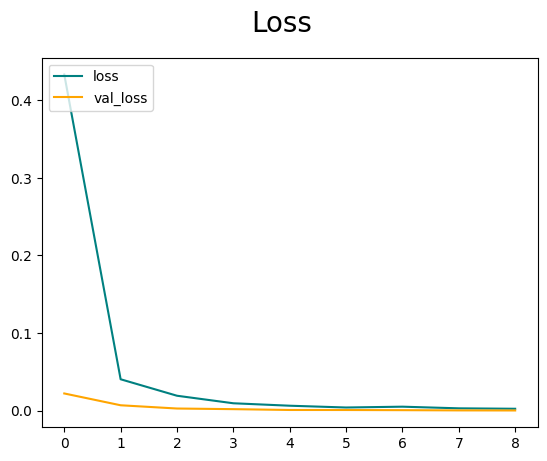

In [17]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

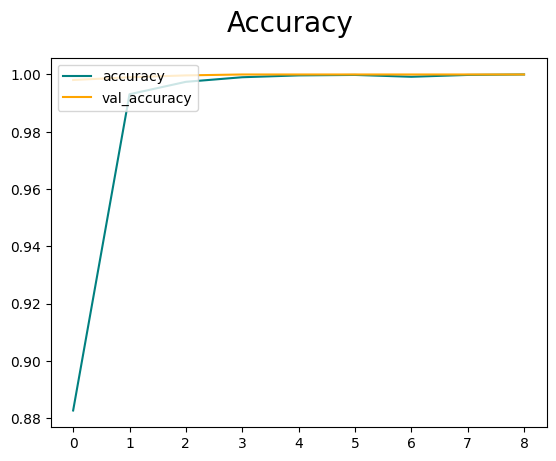

In [18]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Confusion Matrix

W0000 00:00:1724002572.395171      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724002578.276742      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


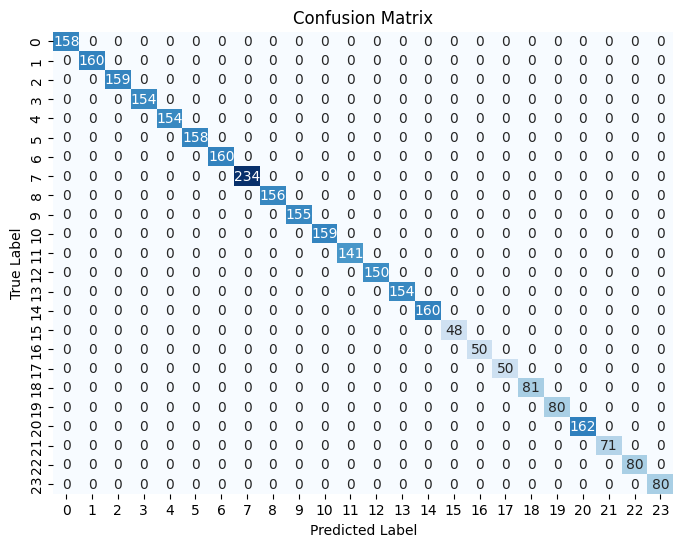

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Initialize lists for true labels and predictions
y_true, y_pred = [], []

# Predict in batches to improve memory efficiency
for images, labels in validation_dataset:
    predictions = model.predict_on_batch(images)  # Efficient batch prediction
    y_true.append(labels.numpy())  # Collect true labels
    y_pred.append(np.argmax(predictions, axis=1))  # Collect predictions

# Flatten the lists to 1D arrays
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Test

In [20]:

def predict_and_show_image(image_path, model, class_names, image_shape):
    # Load the image
    img = cv2.imread(image_path)
    
    # Check if the image was loaded correctly
    if img is None:
        raise ValueError(f"Image at path {image_path} could not be loaded. Please check the path and try again.")
    
    # Convert image from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    img = img.resize(image_shape)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    # Predict the class
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    predicted_class_name = class_names[predicted_class]
    
    # Display the image with prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Prediction: {predicted_class_name}')
    plt.show()

    return predicted_class_name

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


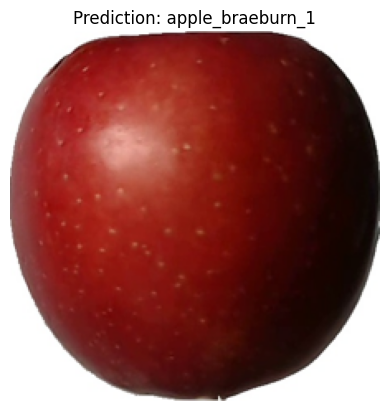

'apple_braeburn_1'

In [21]:
predict_and_show_image('/kaggle/input/fruits/fruits-360_dataset_original-size/fruits-360-original-size/Test/apple_braeburn_1/r0_103.jpg', model, class_names, IMAGE_SHAPE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


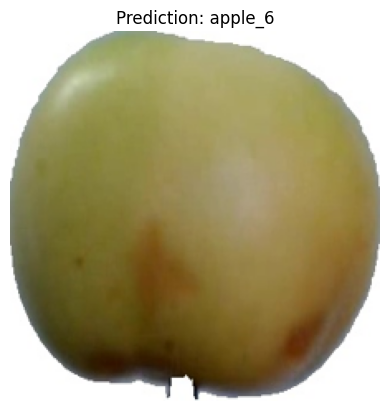

'apple_6'

In [22]:
predict_and_show_image('/kaggle/input/fruits/fruits-360_dataset_original-size/fruits-360-original-size/Test/apple_6/r0_111.jpg', model, class_names, IMAGE_SHAPE)